# Analysis of Utility of Synthetic South Korean COVID-19 patient data.

In [1]:
import itertools

from pointpats import PointPattern
from pointpats.distance_statistics import l_test

import matplotlib.pyplot as plt

from scipy.spatial import KDTree

from pyproj import Proj
from geopy.geocoders import Nominatim

from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant

from helper_functions import *

In [2]:
train_data = pd.read_csv("../Data/SK/cleaned_sk_data.csv")

In [3]:
sXs_mnl = [pd.read_csv("../Data/SK/Synthetic Datasets/gmm_and_mnl_" + str(i) + ".csv") for i in range(20)]
ad_sXs_mnl = [pd.read_csv("../Data/SK/Synthetic Datasets/ad_gmm_and_mnl_" + str(i) + ".csv") for i in range(20)]

sXs_cart = [pd.read_csv("../Data/SK/Synthetic Datasets/gmm_and_cart_" + str(i) + ".csv") for i in range(20)]
ad_sXs_cart = [pd.read_csv("../Data/SK/Synthetic Datasets/ad_gmm_and_cart_" + str(i) + ".csv") for i in range(20)]

sXs_mostly = [pd.read_csv("../Data/SK/Synthetic Datasets/mostly_" + str(i) + ".csv") for i in range(20)]

***

## Utility Measure 1 - pMSE Ratios

In [4]:
ratios_mnl = [pmse_ratio(train_data, Y) for Y in sXs_mnl]
print(np.mean(ratios_mnl))

ratios_ad_mnl = [pmse_ratio(train_data, Y) for Y in ad_sXs_mnl]
print(np.mean(ratios_ad_mnl))

ratios_cart = [pmse_ratio(train_data, Y) for Y in sXs_cart]
print(np.mean(ratios_cart))

ratios_ad_cart = [pmse_ratio(train_data, Y) for Y in ad_sXs_cart]
print(np.mean(ratios_ad_cart))

ratios_mostly = [pmse_ratio(train_data, Y) for Y in sXs_mostly]
np.mean(ratios_mostly)

0.9439372979795884
4.791711226089235
1.0128089382275547


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.069542479756223


1.4078845382665464

***

Save data for plotting in R.

In [5]:
pmse_results = pd.DataFrame({'Dataset': np.arange(1, len(ratios_mnl)+1),
                             'MNL': ratios_mnl,
                             'AD-MNL': ratios_ad_mnl,
                             'CART': ratios_cart,
                             'AD-CART': ratios_ad_cart,
                             'MOSTLY.AI': ratios_mostly})

pmse_results = pmse_results.melt(id_vars=["Dataset"], value_vars=["MNL", "AD-MNL", "CART", "AD-CART", "MOSTLY.AI"], var_name="Type")
pmse_results.to_csv('../Results/SK/pmse_metrics.csv', index=False)

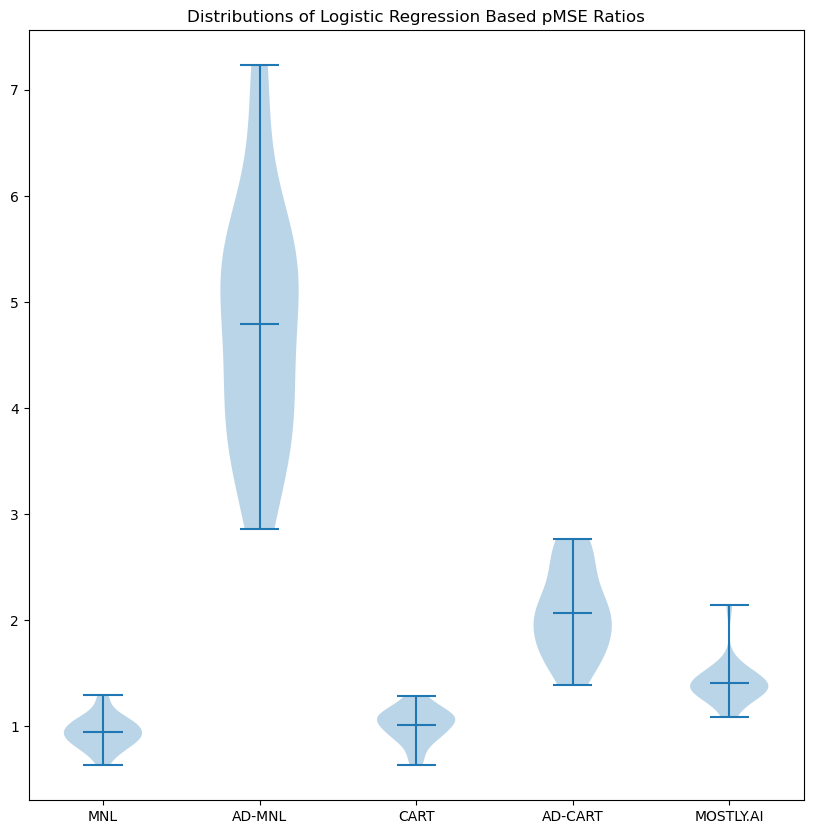

In [6]:
# Combine data
plot_data = list([ratios_mnl, ratios_ad_mnl, ratios_cart, ratios_ad_cart, ratios_mostly])

fig, ax = plt.subplots(figsize=(10,10))

xticklabels = ["MNL", "AD-MNL", "CART", "AD-CART", "MOSTLY.AI"]
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(xticklabels)

ax.violinplot(plot_data, showmeans=True)

plt.title("Distributions of Logistic Regression Based pMSE Ratios")

plt.show()

***

# Utility Measure 2: Visual Comparison of Locations

Visual comparison of location distributions.

Save select data sets for plotting locations in R.

In [7]:
locations = pd.concat([pd.concat([pd.Series(np.repeat('Original', train_data.shape[0])), train_data.loc[:,['latitude', 'longitude', 'state']]], axis=1),
                       pd.concat([pd.Series(np.repeat('MNL', sXs_cart[0].shape[0])), sXs_cart[0].loc[:,['latitude', 'longitude', 'state']]], axis=1),
                       pd.concat([pd.Series(np.repeat('AD - MNL', ad_sXs_cart[0].shape[0])), ad_sXs_cart[0].loc[:,['latitude', 'longitude', 'state']]], axis=1),
                       pd.concat([pd.Series(np.repeat('MOSTLY.AI', sXs_mostly[0].shape[0])), sXs_mostly[0].loc[:,['latitude', 'longitude', 'state']]], axis=1)]).reset_index(drop=True)

locations.to_csv('../Results/SK/locations.csv', index=False)

In [8]:
def scatter_plot(ax1, location_data, plot_title, xlab, ylab):
    
    ax1.scatter(location_data.longitude, location_data.latitude)
    
    ax1.set_title(plot_title)
    ax1.set_xlabel(xlab)
    ax1.set_ylabel(ylab)
    ax1.set_ylim(-4, 2)
    ax1.set_xlim(-2, 2.5)

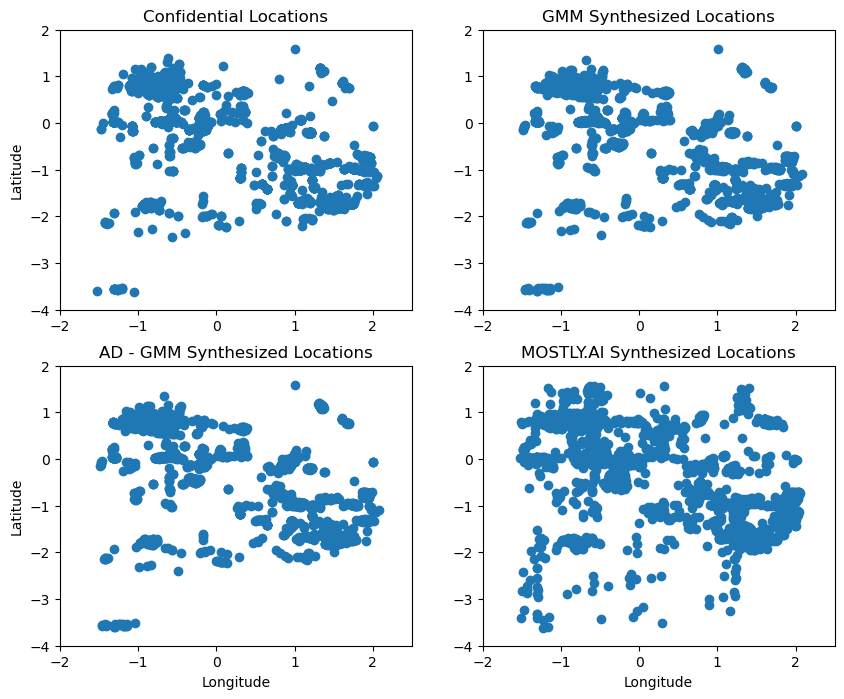

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(10,8))
scatter_plot(ax[0,0], train_data, "Confidential Locations", "", "Latitude")
scatter_plot(ax[0,1], sXs_cart[0], "GMM Synthesized Locations", "", "")
scatter_plot(ax[1,0], ad_sXs_cart[0], "AD - GMM Synthesized Locations", "Longitude", "Latitude")
scatter_plot(ax[1,1], sXs_mostly[0], "MOSTLY.AI Synthesized Locations", "Longitude", "")

***

# Utility Metric 3: Analysis Specific Utility

###  * L1 distance between confidential and synthetic coefficient estimates
###  * Confidence interval ratio
###  * Sign, Significance, and Overlap (SSO)

Analysis specific utility.

Use logistic regression to predict COVID-19 deaths based on latitude and longitude, age, and sex.

Compute the model for the original data.

***

In [10]:
def age_binary(data_set):
    new_age = pd.Series(np.repeat(0, data_set.shape[0]))
    new_age.loc[data_set.age==6] = 1
    new_age.loc[data_set.age==7] = 1
    new_age.loc[data_set.age==8] = 1
    new_age.loc[data_set.age==9] = 1

    data_set['age'] = new_age

    return data_set

In [11]:
age_binary(train_data)

,latitude,longitude,sex,age,state
0,0.944157,-1.010655,1,0,0
1,0.889746,-0.694899,1,0,0
2,0.917482,-0.682299,1,0,0
3,0.916660,-0.682551,1,0,0
4,0.886074,-0.668883,1,0,0
...,...,...,...,...,...
6707,0.881500,-0.925307,1,0,0
6708,-1.728784,1.470871,1,0,0
6709,-1.548071,1.557316,1,0,0
6710,-1.549392,1.555785,1,0,0


***

In [12]:
def logit_param_fetcher(data, y, X):
    predictors = data.loc[:, X]
    predictors = add_constant(predictors)
    state_logit = Logit(endog=data.loc[:, y], exog=predictors)
    logit_results = state_logit.fit()
    return {"params": logit_results.params, 
            "l_var": np.diag(logit_results.cov_params()),
            "CI": logit_results.conf_int().reset_index(drop=True)}

Compute point estimate similarity (L1 distance between synthetic and original coefficients).

Do for one type of synthetic data sets for now.

In [13]:
logit_train = logit_param_fetcher(data=train_data, y='state', X=['latitude', 'longitude', 'sex', 'age'])

Optimization terminated successfully.
         Current function value: 0.034034
         Iterations 11


***

In [ ]:
data=train_data
y='state'
X=['latitude', 'longitude', 'sex', 'age']

predictors = data.loc[:, X]
predictors = add_constant(predictors)
state_logit = Logit(endog=data.loc[:, y], exog=predictors)
logit_results = state_logit.fit()

In [ ]:
logit_results.summary()

***

***

In [ ]:
logit_train

Of the original estimates, the only statistically significant coefficient is for the effect of `age` on `state`: older individuals have a higher probability of passing away from COVID-19. We are interested in whether the synthetic data estimates preserve this inference, while also preserving the conclusions that none of the other variables have a statistically significant effect.

We'll start with the L1 distances of the coefficients across the individual synthetic data sets.

Now, write a function that performs all previous steps given a synthetic data set and the train data set, returning a dataframe with the L1 differences in coefficients and a column that identifies the data type.

In [14]:
def coef_L1_calc(original_data, synthetic_datasets, synthetic_data_type):

    # copy synthetic datasets so they don't get edited on a global scope
    all_synth = synthetic_datasets.copy()

    # train a logistic regression model with state as the target and lat, long, sex, age, and sex*age as predictors
    # function returns all parameter estimates, standard errors, and confidence intervals for the training data
    logit_train = logit_param_fetcher(data=original_data, y='state', X=['latitude', 'longitude', 'sex', 'age'])

    # estimate the same logistic regression model for all synthetic data sets and save params, standard errors, and CIs
    logit_synth = [logit_param_fetcher(data=Y, y='state', X=['latitude', 'longitude', 'sex', 'age']) for Y in synthetic_datasets]

    # create a dataframe with the L1 distances for each coefficient in the columns, (rows are for each synthetic data set)
    # and a column identifying the data type
    l1_frame = pd.DataFrame()

    for i in logit_synth:
        l1_frame = pd.concat([l1_frame, np.abs(i['params'] - logit_train['params'])], axis=1)

    l1_frame = l1_frame.T.reset_index(drop=True)

    l1_frame['Type'] = synthetic_data_type

    return l1_frame

In [15]:
all_synthetic_data = [sXs_mnl, ad_sXs_mnl, sXs_cart, ad_sXs_cart, sXs_mostly]

In [16]:
for i in all_synthetic_data:
    for j in i:
        age_binary(j)

In [17]:
synthetic_data_types = ['MNL', 'AD - MNL', 'CART', 'AD - CART', 'MOSTLY.AI']

In [18]:
all_l1_results = pd.DataFrame()

for i, j in enumerate(all_synthetic_data):
    all_l1_results = pd.concat([all_l1_results, coef_L1_calc(original_data=train_data, synthetic_datasets=j, synthetic_data_type=synthetic_data_types[i]).reset_index()], axis=0)

Optimization terminated successfully.
         Current function value: 0.034034
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.036414
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.031070
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.038899
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.033541
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.034025
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.031396
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.037453
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.034005
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.

In [19]:
all_l1_results = all_l1_results.melt(id_vars=["Type"], value_vars=['const', 'latitude', 'longitude', 'sex', 'age'], var_name="Variable")

Average (across synthetic data sets) L1 distance between original and synthetic coefficients .

In [20]:
all_l1_results.groupby(['Type', 'Variable']).mean('value')

value
Type      Variable           
AD - CART age        0.292006
          const      0.330052
          latitude   0.176473
          longitude  0.123130
          sex        0.736376
AD - MNL  age        0.710174
          const      0.648659
          latitude   0.131155
          longitude  0.212160
          sex        0.619611
CART      age        0.292868
          const      0.325475
          latitude   0.172106
          longitude  0.128794
          sex        0.704043
MNL       age        0.392441
          const      0.443233
          latitude   0.145475
          longitude  0.244905
          sex        0.281241
MOSTLY.AI age        0.361412
          const      0.419380
          latitude   0.183277
          longitude  0.222913
          sex        0.385109

***

***

Repeat the above analysis, but when using combining rules.

Need to combine estimates across all synthetic data sets for each synthesis method.

Now, write a function that calculates the combined point estimates and confidence intervals, given the estimates from a set of synthetic data sets.

Calculate point estimate similarity for all synthesis methods for combined estimates.

In [21]:
all_logit_results = []
for i, j in enumerate(synthetic_data_types):
    all_logit_results.append([logit_param_fetcher(data=Z, y='state', X=['latitude', 'longitude', 'sex', 'age']) for Z in all_synthetic_data[i]])

Optimization terminated successfully.
         Current function value: 0.036414
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.031070
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.038899
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.033541
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.034025
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.031396
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.037453
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.034005
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.033132
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.

In [22]:
m = 20

In [23]:
all_combined_l1_results = pd.DataFrame()

for i, j in enumerate(all_logit_results):
    all_combined_l1_results = pd.concat([all_combined_l1_results, combined_estimates(synthetic_estimates=j, original_estimates=logit_train, type=synthetic_data_types[i], num_synthetic_datasets=m, n=train_data.shape[0], nsynth=np.max([x.shape[0] for x in all_synthetic_data[i]]))], axis=0)

In [24]:
all_combined_l1_results

,Point Estimate,Lower,Upper,Type,L1 Point Estimate,Synthetic CI Width,Original CI Width,CI Ratio
0,-7.430826,-8.536809e+00,-6.324843e+00,MNL,0.377582,2.211966e+00,1.883563,1.174352e+00
1,0.039561,-4.088799e-01,4.880016e-01,MNL,0.084354,8.968815e-01,0.865465,1.036300e+00
2,0.042873,-4.101391e-01,4.958855e-01,MNL,0.238505,9.060246e-01,0.898001,1.008935e+00
3,1.188671,4.510169e-01,1.926325e+00,MNL,0.254489,1.475308e+00,1.248880,1.181305e+00
4,3.735676,-1.584789e+06,1.584796e+06,MNL,0.243106,3.169585e+06,1.710084,1.853468e+06
0,-7.174078,-8.324464e+00,-6.023693e+00,AD - MNL,0.634330,2.300771e+00,1.883563,1.221499e+00
1,0.044014,-4.292777e-01,5.173051e-01,AD - MNL,0.079901,9.465828e-01,0.865465,1.093727e+00
2,0.073060,-4.113399e-01,5.574607e-01,AD - MNL,0.208318,9.688006e-01,0.898001,1.078841e+00
3,0.823550,1.605913e-01,1.486508e+00,AD - MNL,0.619611,1.325917e+00,1.248880,1.061685e+00
4,3.293109,-4.512519e+06,4.512526e+06,AD - MNL,0.685673,9.025045e+06,1.710084,5.277546e+06


Need to calculate the following:

* L1 distance between the original and combined estimates from each synthesis method
* Confidence interval ratio for each combined confidence interval
* Sign, Significance, and Overlap for the combined confidence intervals

### Debugging combination function

In [ ]:
synthetic_estimates = all_logit_results[-1]
original_estimates = logit_train
type = "MOSTLY.AI"
num_synthetic_datasets = m
n = train_data.shape[0]
nsynth = train_data.shape[0]

In [ ]:
# the combined point estimate (q-bar_m)
qms = []
for i in ['const', 'latitude', 'longitude', 'sex', 'age', 'sex_age']:
    qms.append(np.mean([j['params'][i] for j in synthetic_estimates]))

In [ ]:
# the values for b_m
bms = []
for i, j in enumerate(['const', 'latitude', 'longitude', 'sex', 'age', 'sex_age']):
    bms.append((1/(m-1))*np.sum([(k['params'][j] - qms[i])**2 for k in synthetic_estimates]))

In [ ]:
bms

In [ ]:
# the values for u-bar_m
ums = []
for i, j in enumerate(['const', 'latitude', 'longitude', 'sex', 'age', 'sex_age']):
    ums.append(np.mean([j['l_var'][i] for j in synthetic_estimates]))

In [ ]:
ums

In [ ]:
# calculate variance of qms estimates
Tf = (1 + (1/m)) * np.array(bms) - np.array(ums)

In [ ]:
delta = 1*(Tf<0)

In [ ]:
nsynth=np.max([x.shape[0] for x in all_synthetic_data[-2]])

In [ ]:
Tfstar = (Tf>0) * Tf + delta*((nsynth/n) * np.array(ums))

In [ ]:
Tfstar

In [ ]:
# calculate degrees of freedom
vf = (m - 1) * (1 - np.array(ums)/((1 + 1/m) * np.array(bms)))**2

In [ ]:
(m-1) * (1 - np.array(ums)/((1 + (1/m)) * np.array(bms)))**2

In [ ]:
vf

In [ ]:
# upper and lower CI bounds
upper = pd.Series(np.array(qms) + t.ppf(q=0.975, df=vf)*np.sqrt(Tfstar))

In [ ]:
Tfstar

In [ ]:
np.sqrt(Tfstar)

In [ ]:
upper

In [ ]:
t.ppf(q=0.975, df=vf)

In [ ]:
vf

In [ ]:
lower = pd.Series(np.array(qms) - t.ppf(q=0.975, df=vf)*np.sqrt(Tfstar))

In [ ]:





    
    

    



    cis = pd.concat([pd.Series(qms), lower, upper], axis=1)

    cis.columns = ['Point Estimate', 'Lower', 'Upper']

    cis['Type'] = type

    # calculate the L1 distance for the point estimates
    cis['L1 Point Estimate'] = np.abs(cis['Point Estimate'] - original_estimates['params'].reset_index(drop=True))

    # calculate the confidence interval ratio (synthetic width / original width)
    cis['Synthetic CI Width'] = cis['Upper'] - cis['Lower']
    cis['Original CI Width'] = original_estimates['CI'].iloc[:,1] - original_estimates['CI'].iloc[:,0]
    cis['CI Ratio'] = cis['Synthetic CI Width'] / cis['Original CI Width']

In [ ]:
[X['CI'] for X in synthetic_estimates]

In [ ]:
# def logit_ci_fetcher(model_data):
#     predictors = model_data.loc[:, ["latitude", "longitude", "sex", "age"]]
#     predictors = add_constant(predictors)
#     state_logit = Logit(endog=model_data.loc[:, 'state'], exog=predictors)
#     logit_results = state_logit.fit()
#     return logit_results.conf_int().reset_index(drop=True)

In [ ]:
# def standardized_param_diff(orig_data, synth_data):
#     orig_params = logit_param_getter(orig_data)
#     synth_params = logit_param_getter(synth_data)
#     stan_params = [np.abs(j - synth_params['params'][i]) / orig_params['l_se'][i] for i,j in enumerate(orig_params['params'])]
#     return pd.Series(stan_params)

In [ ]:
synthetic_data_sets = [holdout_data, sXs_mnl_pmse, sXs_mnl_inf_pmse, sXs_cart_mb_pmse, sXs_cart_mb_inf_pmse, sXs_mostly]
median_stan_coefs = [np.median(pd.concat([standardized_param_diff(train_data, x) for x in Y], axis=1)) for Y in synthetic_data_sets]
std_stan_coefs = [np.std(pd.concat([standardized_param_diff(train_data, x) for x in Y], axis=1), ddof=1) for Y in synthetic_data_sets]

In [ ]:
median_stan_coefs

Calculate confidence interval overlap for a model applied to two data sets.

In [ ]:
def interval_overlap(train_dataset, synth_dataset):
    train_ci = logit_ci_getter(train_dataset)
    synth_ci = logit_ci_getter(synth_dataset)
    
    IQ_list = []
    for i,row in train_ci.iterrows():
    
        us = synth_ci.iloc[int(i),1]
        ls = synth_ci.iloc[int(i),0]
        uo = row[1]
        lo = row[0]
    
        ui = np.min([uo, us])
    
        li = np.max([lo, ls])
    
        IQ_list.append( 0.5 * ( (ui - li)/(uo - lo) + (ui - li)/(us - ls) ) )
        
    return IQ_list

In [ ]:
holdout_intervals = np.vstack([interval_overlap(train_data, x) for x in holdout_data])
mnl_pmse_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_mnl_pmse])
mnl_pmse_inf_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_mnl_inf_pmse])
# cart_ks_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_cart_ks])
# cart_pmse_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_cart_pmse])
# cart_ks_mb_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_cart_mb_ks])
cart_pmse_mb_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_cart_mb_pmse])
cart_pmse_mb_inf_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_cart_mb_inf_pmse])
mostly_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_mostly])

In [ ]:
np.median(holdout_intervals)

In [ ]:
np.median(mnl_pmse_intervals)

In [ ]:
np.median(mnl_pmse_inf_intervals)

In [ ]:
np.median(cart_pmse_mb_intervals)

In [ ]:
np.median(cart_pmse_mb_inf_intervals)

In [ ]:
np.median(mostly_intervals)

In [ ]:
def interval_overlap_plot(ax1, plotting_data, plot_title):
    
    xticklabels = ["Holdout", "MNL", "MNL - Inference", "CART", "CART - Inference", "MOSTLY.AI"]
    ax1.set_xticks([1, 2, 3, 4, 5, 6])
    ax1.set_xticklabels(xticklabels)
    
    ax1.violinplot(plotting_data, showmeans=True)
    ax1.set_title(plot_title)

    ax1.set_ylabel('Interval Overlap')
    ax1.set_ylim(-1.00, 1.00)

In [ ]:
# Combine data
intercept_vals = list([holdout_intervals[:,0], mnl_pmse_intervals[:,0], mnl_pmse_inf_intervals[:,0], cart_pmse_mb_intervals[:,0], cart_pmse_mb_inf_intervals[:,0], mostly_intervals[:,0]])

latitude_vals = list([holdout_intervals[:,1], mnl_pmse_intervals[:,1], mnl_pmse_inf_intervals[:,1], cart_pmse_mb_intervals[:,1], cart_pmse_mb_inf_intervals[:,1], mostly_intervals[:,1]])

longitude_vals = list([holdout_intervals[:,2], mnl_pmse_intervals[:,2], mnl_pmse_inf_intervals[:,2], cart_pmse_mb_intervals[:,2], cart_pmse_mb_inf_intervals[:,2], mostly_intervals[:,2]])

sex_vals = list([holdout_intervals[:,3], mnl_pmse_intervals[:,3], mnl_pmse_inf_intervals[:,3], cart_pmse_mb_intervals[:,3], cart_pmse_mb_inf_intervals[:,3], mostly_intervals[:,3]])

age_vals = list([holdout_intervals[:,4], mnl_pmse_intervals[:,4], mnl_pmse_inf_intervals[:,4], cart_pmse_mb_intervals[:,4], cart_pmse_mb_inf_intervals[:,4], mostly_intervals[:,4]])

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(12,10))

interval_overlap_plot(ax[0,0], intercept_vals, "Intercept")
interval_overlap_plot(ax[0,1], latitude_vals, "Latitude")
interval_overlap_plot(ax[1,0], longitude_vals, "Longitude")
interval_overlap_plot(ax[1,1], sex_vals, "Sex")
interval_overlap_plot(ax[2,0], age_vals, "Age")

plt.tight_layout()

***